d:\Anaconda\envs\condaenvironment\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


成功预处理 38 场洪水事件。
确定的共享单位线长度 common_n_uh: 55

开始优化共享单位线...
平滑因子: 0.1, 单峰惩罚因子: 10000.0

共享单位线优化完成！

--- 正在绘制拟合效果最差的三场洪水事件 ---


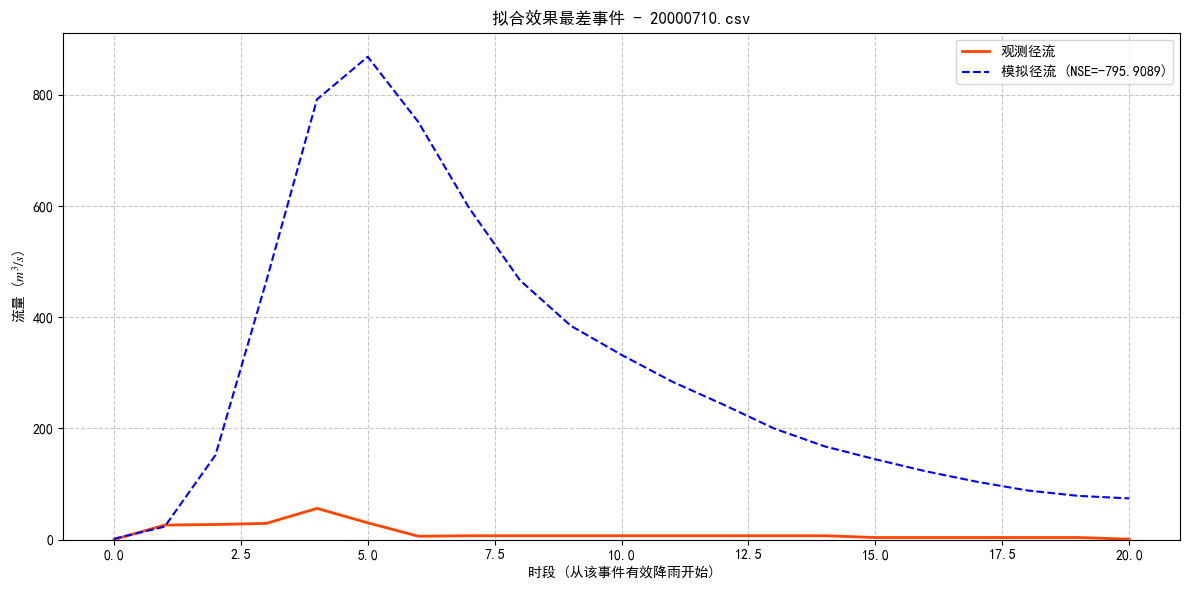

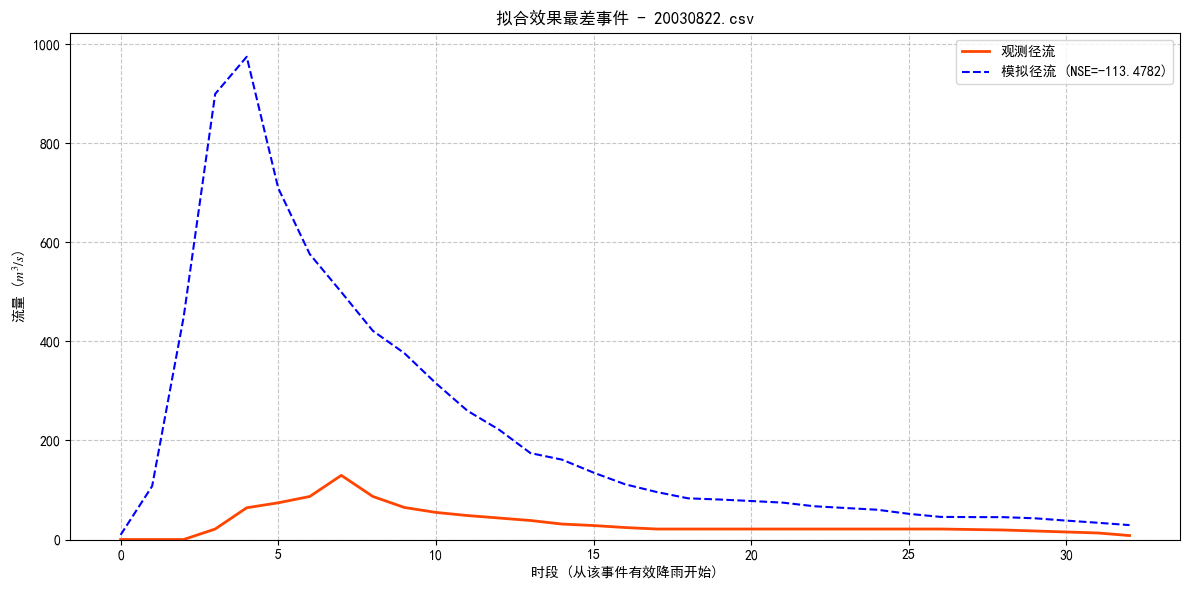

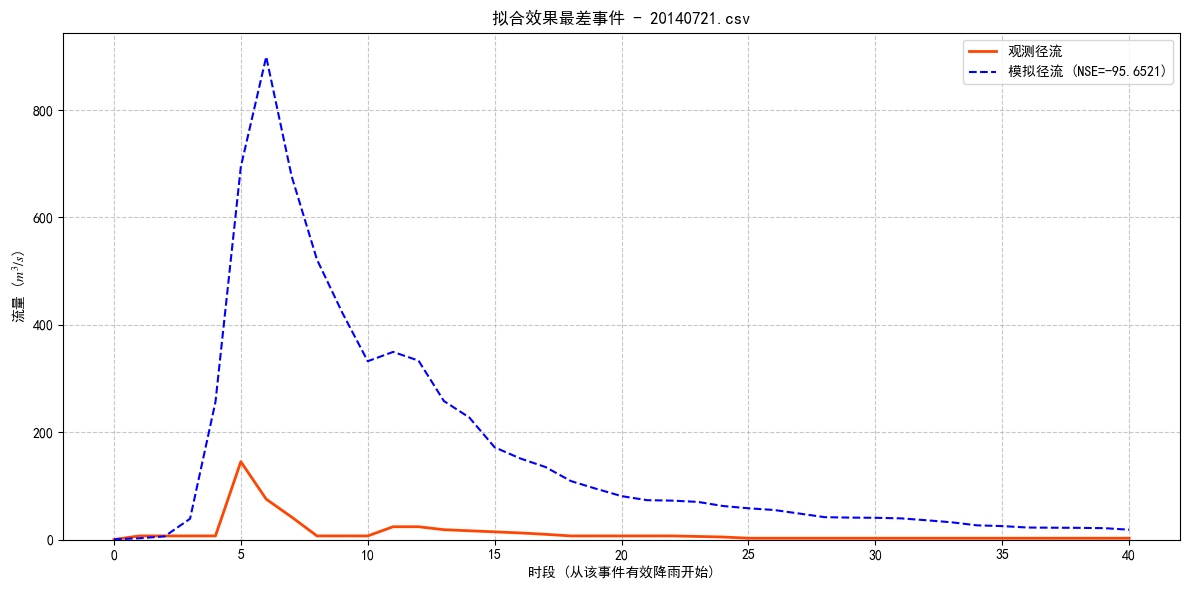


--- 正在绘制拟合效果最好的三场洪水事件 ---


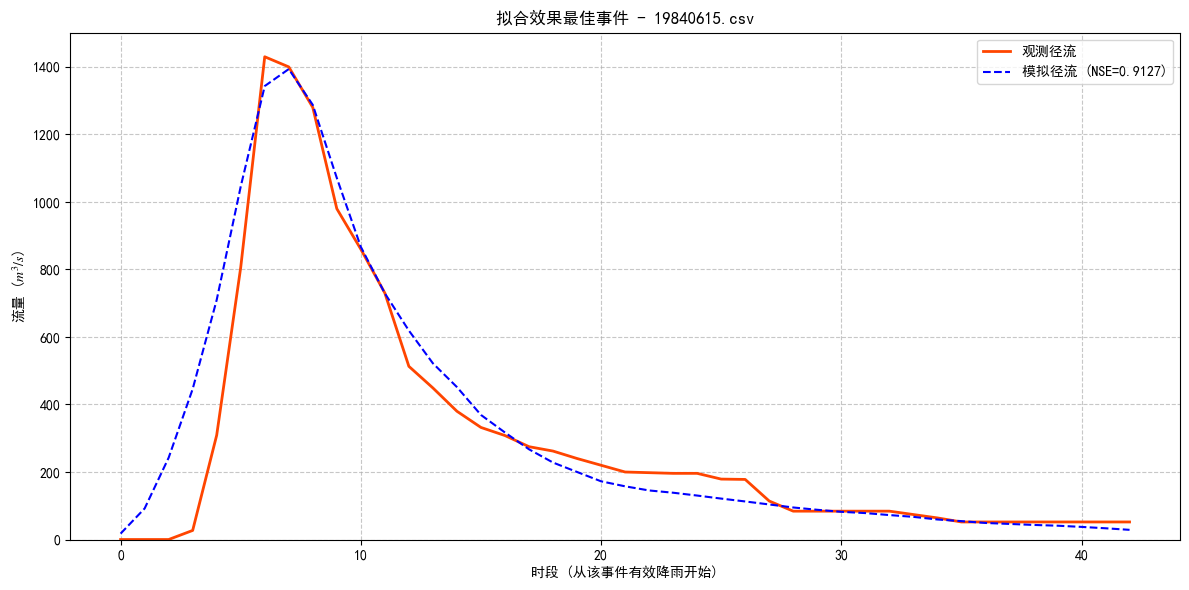

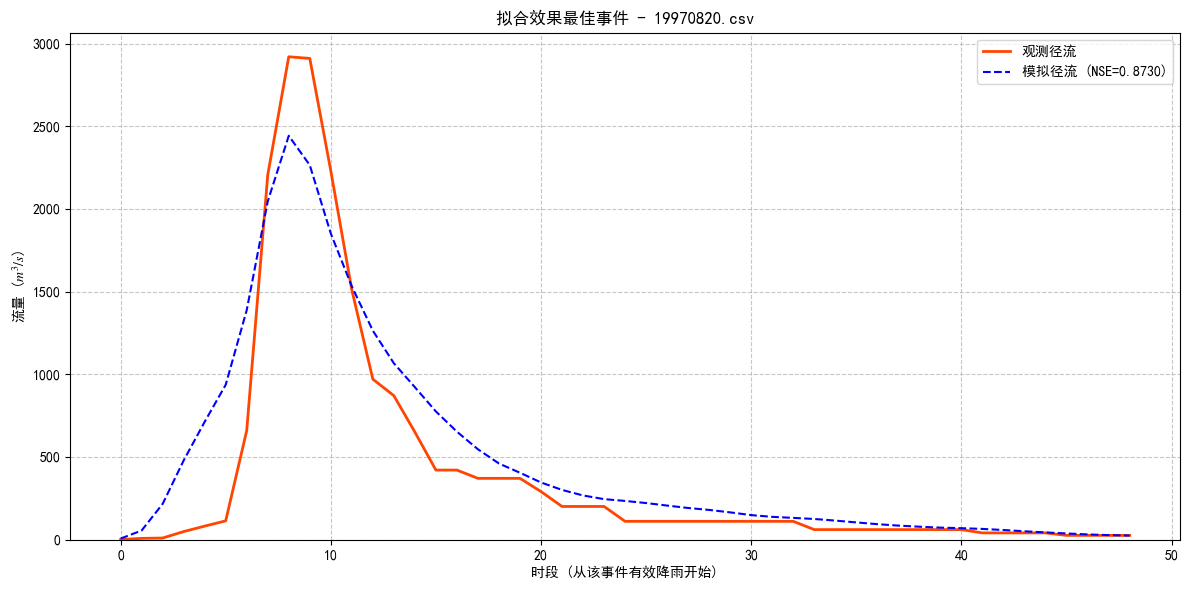

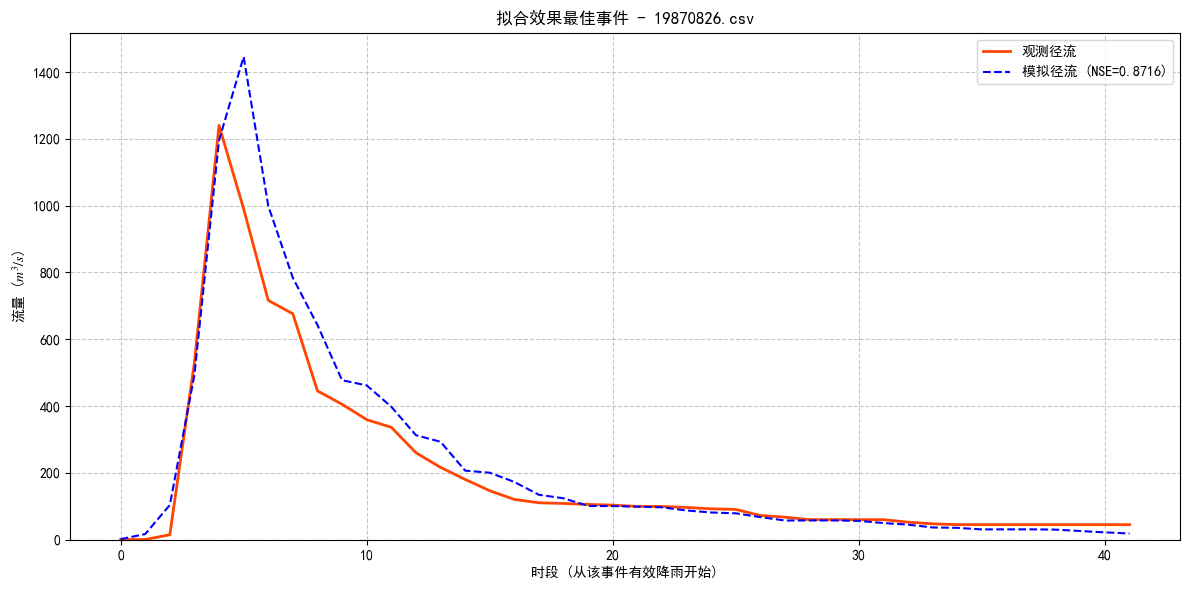

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 全局常量 ---
R_UH = 10.0
DELTA_T_HOURS = 3.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None;
        for enc in encodings_to_try:
            try: df = pd.read_csv(csv_filepath, encoding=enc); break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col, net_rain_col, direct_runoff_col = '时间', '泰森多边形面雨量', '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    if np.sum(net_rain) < 1e-6: return None
    
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None
    last_rain_idx = len(net_rain) - 1
    for i in range(len(net_rain) - 1, first_rain_idx - 1, -1):
        if net_rain[i] > 1e-6: last_rain_idx = i; break
        
    P_eff_event = net_rain[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None
    Q_obs_eff_event = direct_runoff[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
        
    return {"P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event, "m_eff": m_eff_event, "n_specific": n_event_specific, "filepath": csv_filepath}

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh):
    total_fit_loss = 0
    if len(U_params) != common_n_uh: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def calculate_nse(q_obs, q_sim):
    if len(q_obs) != len(q_sim) or len(q_obs) == 0: return np.nan
    mean_obs = np.mean(q_obs)
    denominator = np.sum((q_obs - mean_obs)**2)
    if denominator == 0: return 1.0 if np.allclose(q_sim, q_obs) else -np.inf
    else: return 1 - (np.sum((q_obs - q_sim)**2) / denominator)

def plot_fit_comparison(event_data, U_optimized, plot_title, nse_value):
    P_event, Q_obs_event = event_data["P_eff"], event_data["Q_obs_eff"]
    event_filename = os.path.basename(event_data["filepath"])
    Q_sim_full = convolve_uh(P_event, U_optimized, R_UH)
    Q_sim_plot = Q_sim_full[:len(Q_obs_event)]
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(Q_obs_event)), Q_obs_event, label='观测径流', color='orangered', linewidth=2)
    plt.plot(np.arange(len(Q_sim_plot)), Q_sim_plot, label=f'模拟径流 (NSE={nse_value:.4f})', color='blue', linestyle='--')
    plt.title(f'{plot_title} - {event_filename}')
    plt.xlabel('时段 (从该事件有效降雨开始)')
    plt.ylabel(r'流量 ($m^3/s$)')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.7); plt.ylim(bottom=0); plt.tight_layout(); plt.show()

# --- 主程序 ---
# 1. & 2. & 3. 数据准备
data_folder = "data_source/" 
try:
    csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
    if not csv_files: exit()
except FileNotFoundError: exit()
all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
if not all_events_processed_data: exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

n_specific_values = [data["n_specific"] for data in all_events_processed_data if data["n_specific"] > 0]
if not n_specific_values: exit()
common_n_uh = int(np.max(n_specific_values))
if common_n_uh <= 1: common_n_uh = max(3, common_n_uh if common_n_uh > 0 else 3)
print(f"确定的共享单位线长度 common_n_uh: {common_n_uh}")

list_of_event_data_for_opt_final = []
for event_data in all_events_processed_data:
    P_eff, Q_obs_eff, m_eff = event_data["P_eff"], event_data["Q_obs_eff"], event_data["m_eff"]
    target_q_len_event = m_eff + common_n_uh - 1
    if target_q_len_event < 0: target_q_len_event = 0
    Q_obs_for_opt_event = np.zeros(target_q_len_event)
    len_to_copy = min(len(Q_obs_eff), target_q_len_event)
    Q_obs_for_opt_event[:len_to_copy] = Q_obs_eff[:len_to_copy]
    list_of_event_data_for_opt_final.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt_event})

# 4. 优化共享单位线
U_initial_guess = np.zeros(common_n_uh)
bounds = [(0, None) for _ in range(common_n_uh)] 
smoothing_factor = 0.1
peak_violation_weight = 10000.0
apply_peak_penalty_in_opt = common_n_uh > 2
print(f"\n开始优化共享单位线...")
print(f"平滑因子: {smoothing_factor}, 单峰惩罚因子: {peak_violation_weight if apply_peak_penalty_in_opt else 'N/A'}")
result_shared_uh = minimize(
    objective_function_multi_event, U_initial_guess,
    args=(list_of_event_data_for_opt_final, R_UH, smoothing_factor, peak_violation_weight, apply_peak_penalty_in_opt, common_n_uh),
    method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 500}
)
U_optimized_shared = result_shared_uh.x if (result_shared_uh.success or result_shared_uh.status in [0,2]) else None
if U_optimized_shared is None: exit()
print("\n共享单位线优化完成！")

# 5. 评估所有事件并排序
all_event_analysis_results = []
for event_data in all_events_processed_data:
    P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
    Q_sim_event_full = convolve_uh(P_event, U_optimized_shared, R_UH)
    Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
    nse_event = calculate_nse(Q_obs_event_full, Q_sim_event_compare)
    all_event_analysis_results.append({"filepath": event_data["filepath"], "NSE": nse_event})

# 按NSE从小到大排序
all_event_analysis_sorted = sorted(all_event_analysis_results, key=lambda x: x["NSE"] if pd.notna(x["NSE"]) and np.isfinite(x["NSE"]) else float('-inf'))

# --- 6. 核心修改：绘制最差和最好的三场洪水拟合图 ---

# 筛选出有效的评估结果
valid_results = [res for res in all_event_analysis_sorted if pd.notna(res["NSE"]) and np.isfinite(res["NSE"])]

if len(valid_results) > 0:
    # 绘制拟合效果最差的三场
    print("\n--- 正在绘制拟合效果最差的三场洪水事件 ---")
    worst_three_events_info = valid_results[:3]
    for event_info in worst_three_events_info:
        worst_event_data = next((data for data in all_events_processed_data if data["filepath"] == event_info["filepath"]), None)
        if worst_event_data:
            plot_fit_comparison(worst_event_data, U_optimized_shared, '拟合效果最差事件', event_info["NSE"])

    # 绘制拟合效果最好的三场
    # 如果事件总数少于6，为了避免重复绘图，只画最好的
    num_to_plot_best = 3 if len(valid_results) >= 6 else (1 if len(valid_results) > 3 else 0)
    if num_to_plot_best > 0:
        print("\n--- 正在绘制拟合效果最好的三场洪水事件 ---")
        best_three_events_info = valid_results[-num_to_plot_best:]
        # 从好到次好绘制，所以倒序
        for event_info in reversed(best_three_events_info):
            best_event_data = next((data for data in all_events_processed_data if data["filepath"] == event_info["filepath"]), None)
            if best_event_data:
                plot_fit_comparison(best_event_data, U_optimized_shared, '拟合效果最佳事件', event_info["NSE"])
else:
    print("\n没有可供评估的有效洪水事件。")

成功预处理 38 场洪水事件。
确定的共享单位线长度 common_n_uh: 55

开始优化共享单位线...
平滑因子: 0.1, 单峰惩罚因子: 10000.0

共享单位线优化完成！

--- 正在绘制拟合效果最差的三场洪水事件 ---


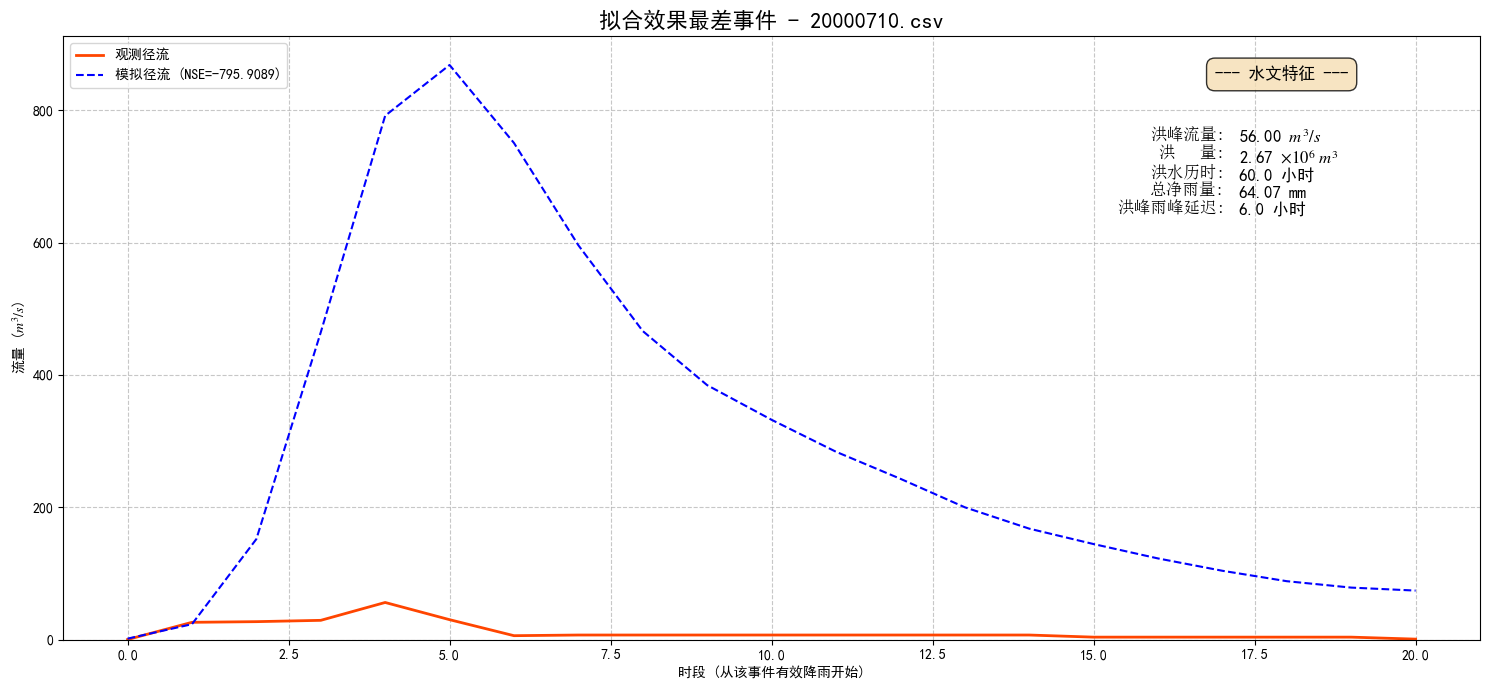

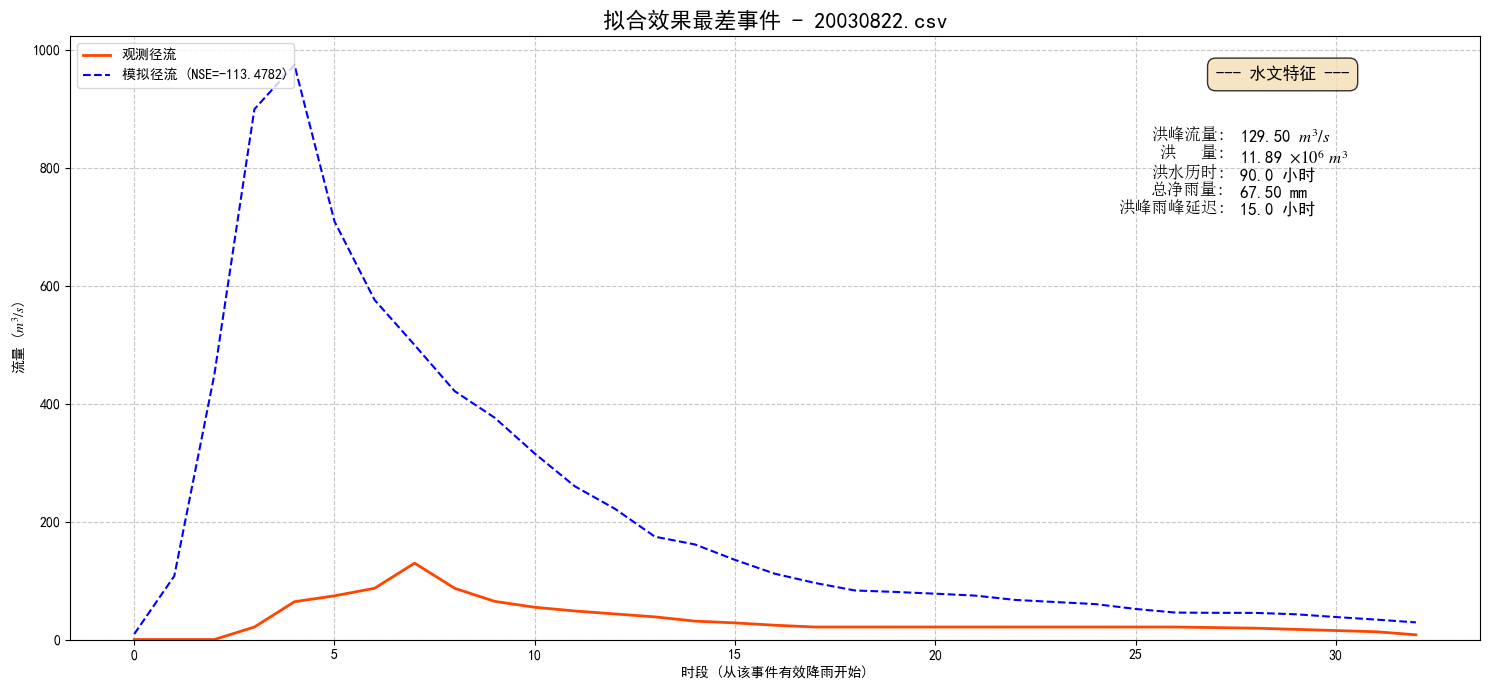

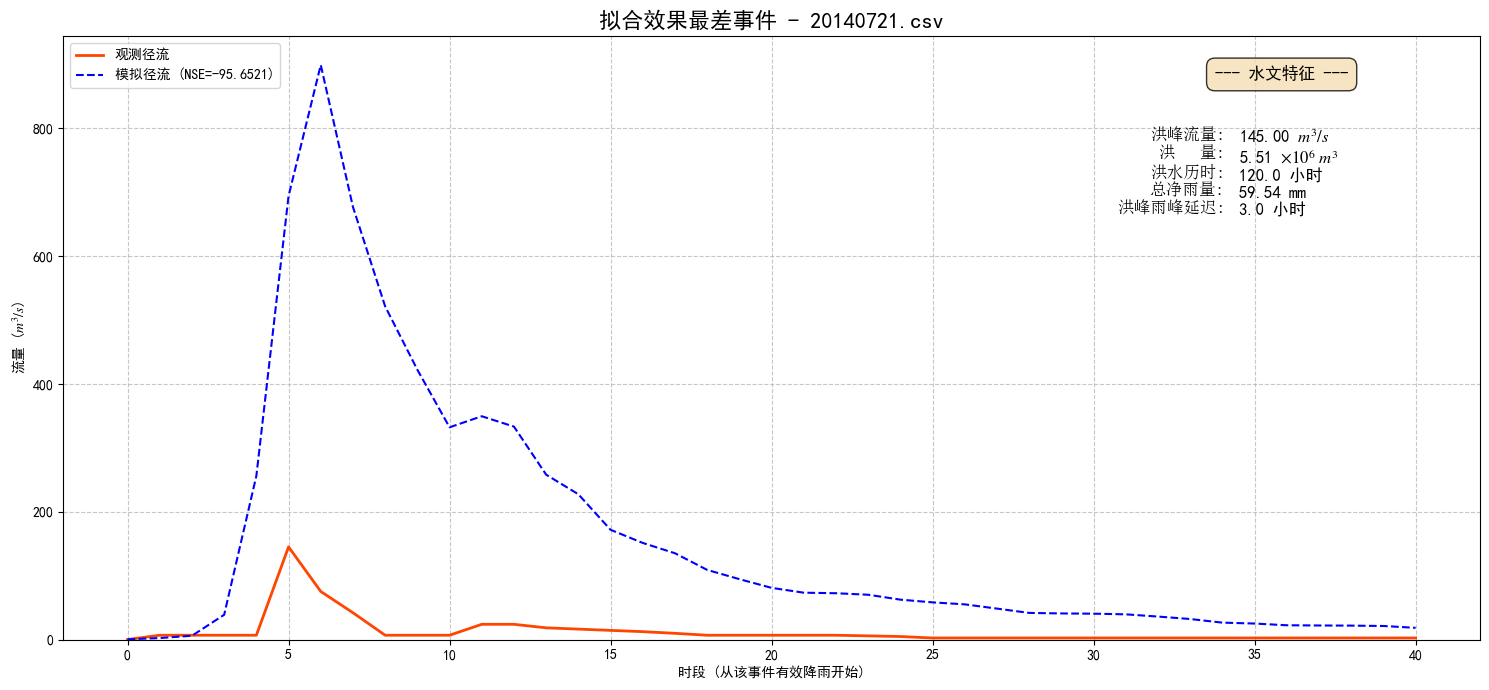


--- 正在绘制拟合效果最好的三场洪水事件 ---


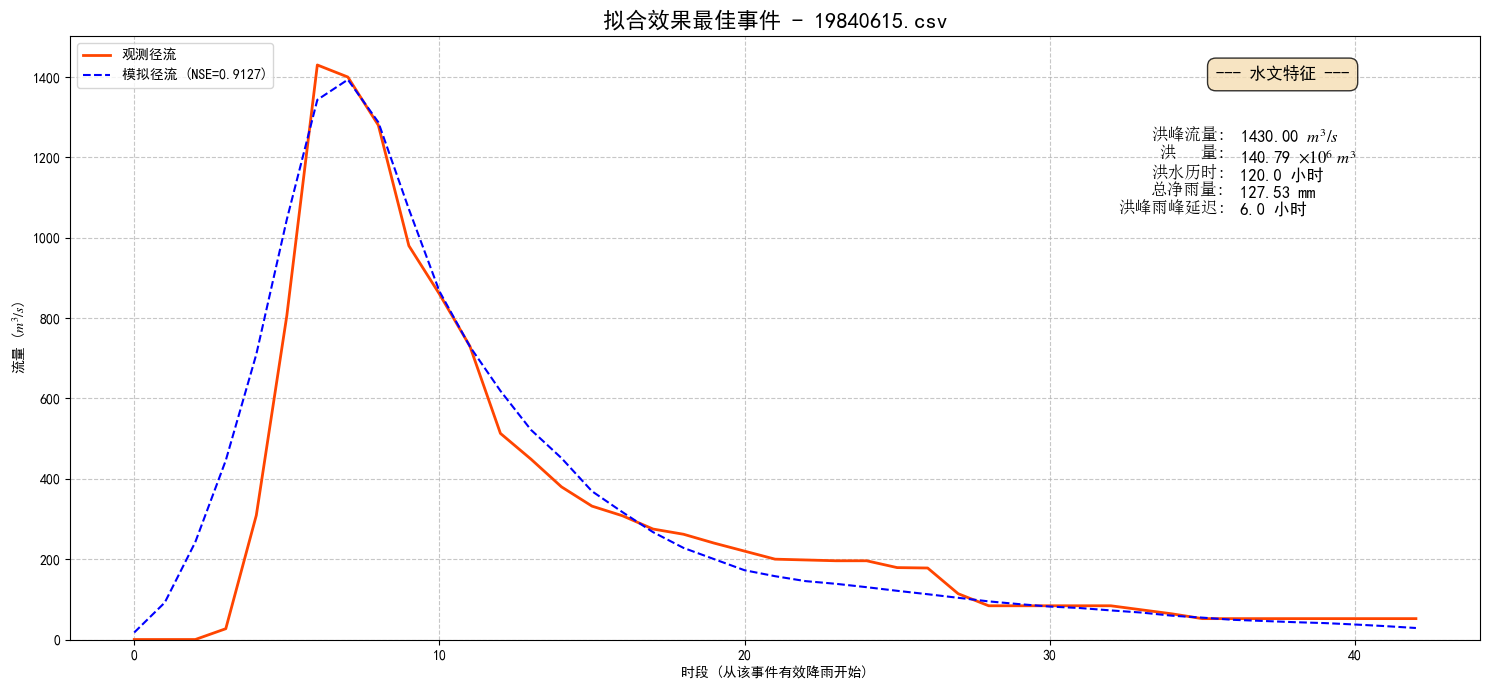

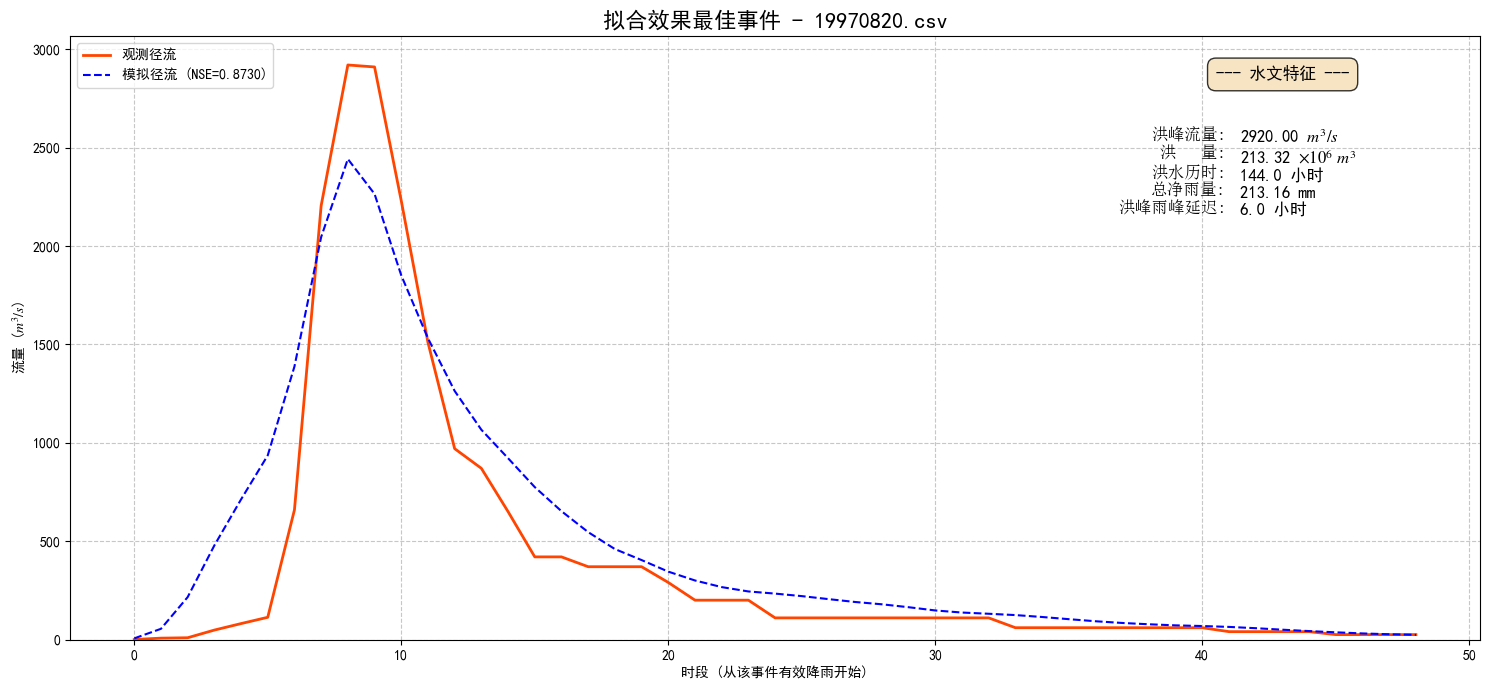

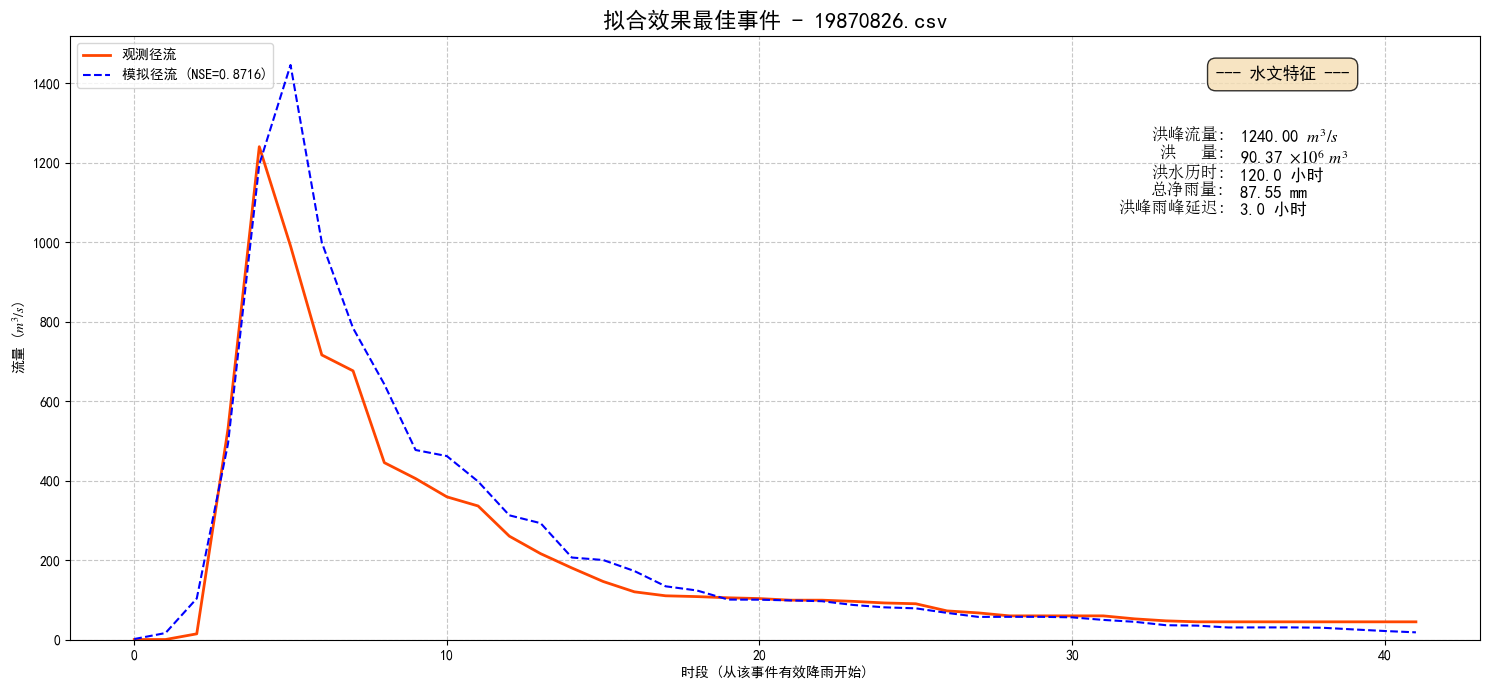

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 全局常量 ---
R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (现在返回更多特征) ---
def process_and_analyze_event(csv_filepath):
    """读取并处理单个洪水事件，并计算其关键水文特征。"""
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None;
        for enc in encodings_to_try:
            try: df = pd.read_csv(csv_filepath, encoding=enc); break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col, net_rain_col, direct_runoff_col = '时间', '泰森多边形面雨量', '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    if np.sum(net_rain) < 1e-6: return None

    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None
    last_rain_idx = len(net_rain) - 1
    for i in range(len(net_rain) - 1, first_rain_idx - 1, -1):
        if net_rain[i] > 1e-6: last_rain_idx = i; break
        
    P_eff_event = net_rain[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None
    Q_obs_eff_event = direct_runoff[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
        
    # --- 计算水文特征 ---
    runoff_indices = np.where(direct_runoff > 1e-6)[0]
    if len(runoff_indices) < 2: return None
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    runoff_duration_hours = (runoff_indices[-1] - runoff_indices[0] + 1) * DELTA_T_HOURS
    t_peak_flow_idx = np.argmax(direct_runoff)
    runoff_volume_m3 = np.sum(direct_runoff) * delta_t_seconds
    total_net_rain = np.sum(net_rain)
    t_peak_rain_idx = np.argmax(net_rain)
    lag_time_hours = (t_peak_flow_idx - t_peak_rain_idx) * DELTA_T_HOURS
    
    return {
        "P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event,
        "m_eff": m_eff_event, "n_specific": n_event_specific,
        "filepath": csv_filepath,
        "features": {
            "洪峰流量": peak_flow, "洪量": runoff_volume_m3,
            "洪水历时": runoff_duration_hours, "总净雨量": total_net_rain,
            "洪峰雨峰延迟": lag_time_hours
        }
    }

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    # ... (与之前版本完全相同) ...
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh):
    # ... (与之前版本完全相同) ...
    total_fit_loss = 0
    if len(U_params) != common_n_uh: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def calculate_nse(q_obs, q_sim):
    # ... (与之前版本完全相同) ...
    if len(q_obs) != len(q_sim) or len(q_obs) == 0: return np.nan
    mean_obs = np.mean(q_obs)
    denominator = np.sum((q_obs - mean_obs)**2)
    if denominator == 0: return 1.0 if np.allclose(q_sim, q_obs) else -np.inf
    else: return 1 - (np.sum((q_obs - q_sim)**2) / denominator)

# --- 修改后的绘图函数 ---
# --- 修改后的绘图函数 ---
def plot_fit_comparison_with_features(event_data, U_optimized, plot_title, nse_value):
    P_event, Q_obs_event = event_data["P_eff"], event_data["Q_obs_eff"]
    event_filename = os.path.basename(event_data["filepath"])
    features = event_data["features"]
    
    Q_sim_full = convolve_uh(P_event, U_optimized, R_UH)
    Q_sim_plot = Q_sim_full[:len(Q_obs_event)]
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # 绘制曲线
    ax.plot(np.arange(len(Q_obs_event)), Q_obs_event, label='观测径流', color='orangered', linewidth=2)
    ax.plot(np.arange(len(Q_sim_plot)), Q_sim_plot, label=f'模拟径流 (NSE={nse_value:.4f})', color='blue', linestyle='--')
    
    # --- 核心修改：使用多个text调用来实现文本对齐 ---
    
    # 准备文本内容
    # 注意: 为了对齐，我在“洪”和“量”之间加了全角空格
    labels = [
        '洪峰流量:',
        '洪   量:',
        '洪水历时:',
        '总净雨量:',
        '洪峰雨峰延迟:'
    ]
    values = [
        f"{features['洪峰流量']:.2f} " + r'$m^3/s$',
        f"{features['洪量'] / 1e6:.2f} " + r'$\times 10^6\ m^3$',
        f"{features['洪水历时']:.1f} 小时",
        f"{features['总净雨量']:.2f} mm",
        f"{features['洪峰雨峰延迟']:.1f} 小时"
    ]
    
    # 将列表转换为带换行符的字符串
    label_text = "\n".join(labels)
    value_text = "\n".join(values)
    
    # 定义文本框的位置和样式
    bbox_props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8)
    
    # 放置标题，并居中对齐
    ax.text(0.86, 0.95, '--- 水文特征 ---', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='center', bbox=bbox_props) # ha='center'
             
    # 放置标签列，右对齐
    ax.text(0.82, 0.85, label_text, transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right', family='SimSun') # ha='right'
             
    # 放置数值列，左对齐
    ax.text(0.83, 0.85, value_text, transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='left') # ha='left'

    
    # 美化图表
    ax.set_title(f'{plot_title} - {event_filename}', fontsize=16)
    ax.set_xlabel('时段 (从该事件有效降雨开始)')
    ax.set_ylabel(r'流量 ($m^3/s$)')
    ax.legend(loc='upper left'); 
    ax.grid(True, linestyle='--', alpha=0.7); 
    ax.set_ylim(bottom=0); 
    plt.tight_layout(); 
    plt.show()

# --- 主程序 ---
# 1. & 2. & 3. 数据准备 (与之前推求共享单位线的版本相同)
data_folder = "data_source/" 
try:
    csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
    if not csv_files: exit()
except FileNotFoundError: exit()
all_events_processed_data = [d for d in [process_and_analyze_event(f) for f in csv_files] if d]
if not all_events_processed_data: exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

n_specific_values = [data["n_specific"] for data in all_events_processed_data if data["n_specific"] > 0]
if not n_specific_values: exit()
common_n_uh = int(np.max(n_specific_values))
if common_n_uh <= 1: common_n_uh = max(3, common_n_uh if common_n_uh > 0 else 3)
print(f"确定的共享单位线长度 common_n_uh: {common_n_uh}")

list_of_event_data_for_opt_final = []
for event_data in all_events_processed_data:
    P_eff, Q_obs_eff, m_eff = event_data["P_eff"], event_data["Q_obs_eff"], event_data["m_eff"]
    target_q_len_event = m_eff + common_n_uh - 1
    if target_q_len_event < 0: target_q_len_event = 0
    Q_obs_for_opt_event = np.zeros(target_q_len_event)
    len_to_copy = min(len(Q_obs_eff), target_q_len_event)
    Q_obs_for_opt_event[:len_to_copy] = Q_obs_eff[:len_to_copy]
    list_of_event_data_for_opt_final.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt_event})

# 4. 优化共享单位线
U_initial_guess = np.zeros(common_n_uh)
bounds = [(0, None) for _ in range(common_n_uh)] 
smoothing_factor = 0.1
peak_violation_weight = 10000.0
apply_peak_penalty_in_opt = common_n_uh > 2
print(f"\n开始优化共享单位线...")
print(f"平滑因子: {smoothing_factor}, 单峰惩罚因子: {peak_violation_weight if apply_peak_penalty_in_opt else 'N/A'}")
result_shared_uh = minimize(
    objective_function_multi_event, U_initial_guess,
    args=(list_of_event_data_for_opt_final, R_UH, smoothing_factor, peak_violation_weight, apply_peak_penalty_in_opt, common_n_uh),
    method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 500}
)
U_optimized_shared = result_shared_uh.x if (result_shared_uh.success or result_shared_uh.status in [0,2]) else None
if U_optimized_shared is None: exit()
print("\n共享单位线优化完成！")

# 5. 评估所有事件并排序
all_event_analysis_results = []
for event_data in all_events_processed_data:
    P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
    Q_sim_event_full = convolve_uh(P_event, U_optimized_shared, R_UH)
    Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
    nse_event = calculate_nse(Q_obs_event_full, Q_sim_event_compare)
    all_event_analysis_results.append({"filepath": event_data["filepath"], "NSE": nse_event})

all_event_analysis_sorted = sorted(all_event_analysis_results, key=lambda x: x["NSE"] if pd.notna(x["NSE"]) and np.isfinite(x["NSE"]) else float('-inf'))

# 6. 绘制最差和最好的三场洪水拟合图
valid_results = [res for res in all_event_analysis_sorted if pd.notna(res["NSE"]) and np.isfinite(res["NSE"])]

if len(valid_results) > 0:
    # 绘制拟合效果最差的三场
    print("\n--- 正在绘制拟合效果最差的三场洪水事件 ---")
    worst_three_events_info = valid_results[:3]
    for event_info in worst_three_events_info:
        worst_event_data = next((data for data in all_events_processed_data if data["filepath"] == event_info["filepath"]), None)
        if worst_event_data:
            plot_fit_comparison_with_features(worst_event_data, U_optimized_shared, '拟合效果最差事件', event_info["NSE"])

    # 绘制拟合效果最好的三场
    num_to_plot_best = 3 if len(valid_results) >= 6 else (1 if len(valid_results) > 3 else 0)
    if num_to_plot_best > 0:
        print("\n--- 正在绘制拟合效果最好的三场洪水事件 ---")
        best_three_events_info = valid_results[-num_to_plot_best:]
        for event_info in reversed(best_three_events_info):
            best_event_data = next((data for data in all_events_processed_data if data["filepath"] == event_info["filepath"]), None)
            if best_event_data:
                plot_fit_comparison_with_features(best_event_data, U_optimized_shared, '拟合效果最佳事件', event_info["NSE"])
else:
    print("\n没有可供评估的有效洪水事件。")

成功读取文件: shared_uh_evaluation_report_with_signed_errors.csv
共读取 38 条记录。

筛选出 22 条 NSE 为正的记录用于绘图。

--- 正在生成 洪量相对误差 分布雨云图 (仅NSE为正的事件) ---


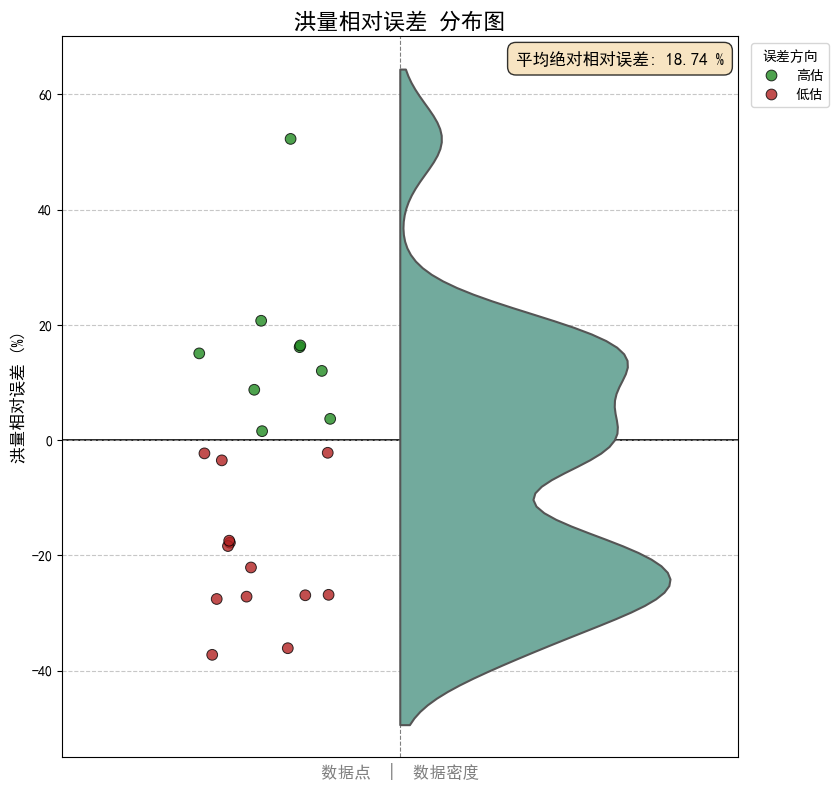


--- 正在生成 洪峰相对误差 分布雨云图 (仅NSE为正的事件) ---


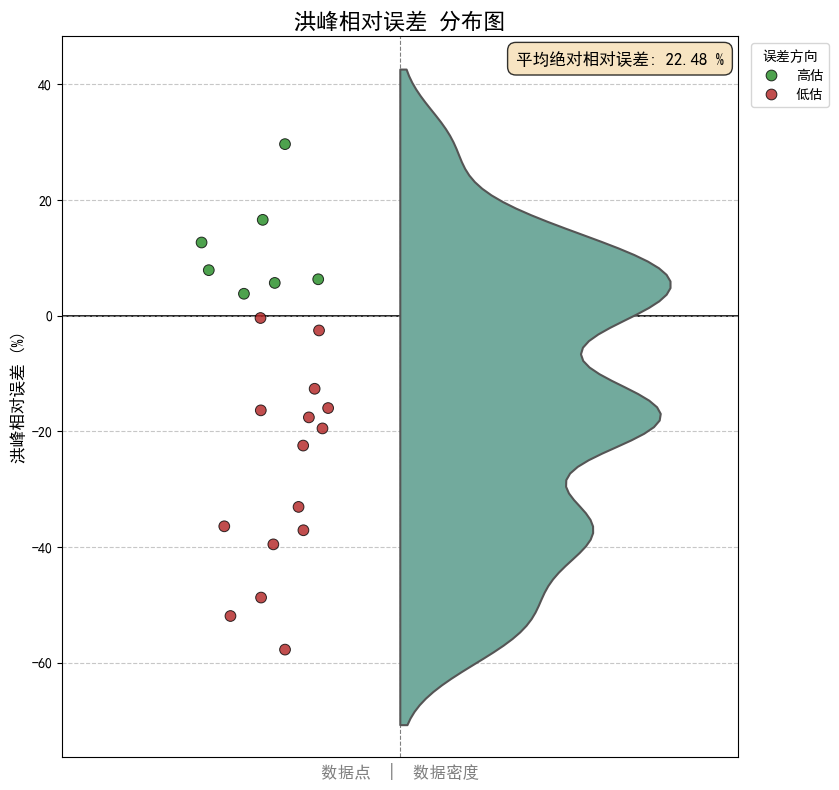

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 绘图函数 ---
def plot_error_raincloud(data_rel, feature_name, palette):
    """
    为给定的误差数据绘制雨云图，解决图例重叠问题并移除'准确'图例项。
    """
    if data_rel.empty:
        print(f"警告: 特征 '{feature_name}' 没有有效数据，无法绘图。")
        return

    # 准备用于绘图的DataFrame
    df_plot = pd.DataFrame({'rel_error': data_rel})
    # '准确' 类别对于绘图是必要的，但我们会在图例中隐藏它
    df_plot['误差方向'] = np.sign(df_plot['rel_error']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})

    # --- 开始绘图 ---
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 1. 绘制小提琴图和散点图 (与之前相同)
    sns.violinplot(y='rel_error', data=df_plot, ax=ax, color="#69b3a2", 
                   inner=None, linewidth=1.5, bw_adjust=0.5, zorder=5)
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    x_scatter = -0.2 + (np.random.rand(len(df_plot)) * 0.2 - 0.1)
    sns.scatterplot(x=x_scatter, y='rel_error', data=df_plot, ax=ax, 
                    hue='误差方向', hue_order=['高估', '低估', '准确'], palette=palette, 
                    s=60, alpha=0.8, edgecolor='black', linewidth=0.7, zorder=10)
                  
    # 2. 计算并准备平均绝对相对误差文本
    mean_abs_rel_error = df_plot['rel_error'].abs().mean()
    stats_text = f"平均绝对相对误差: {mean_abs_rel_error:.2f} %"
    
    # 3. 在图中标注文本 (位置调整，为图例留出空间)
    props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    # 4. 美化图表 (与之前相同)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2, zorder=0)
    ax.set_ylabel(f"{feature_name} (%)", fontsize=12)
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_title(f"{feature_name} 分布图", fontsize=16)
    ax.set_xticks([])
    ax.set_xlim(-0.5, 0.5)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # --- 5. 核心修改：处理图例 ---
    handles, labels = ax.get_legend_handles_labels()
    
    # 找到 "准确" 标签的索引并移除
    try:
        idx_to_remove = labels.index('准确')
        # 从句柄和标签列表中都删除该项
        del handles[idx_to_remove]
        del labels[idx_to_remove]
    except ValueError:
        # 如果没有 "准确" 类别，则什么都不做
        pass
        
    # 创建并放置图例
    # bbox_to_anchor 将图例的左上角定位在坐标轴区域之外
    ax.legend(handles, labels, title='误差方向', loc='upper left', bbox_to_anchor=(1.01, 1.0))
    
    # 使用 fig.tight_layout() 来确保图例能完整显示
    fig.tight_layout(rect=[0, 0, 0.85, 1]) # rect 的第三个参数减小，为右侧图例留出空间
    plt.show()

# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义要读取的文件路径
    csv_filepath = "shared_uh_evaluation_report_with_signed_errors.csv"
    
    # 2. 读取CSV文件
    try:
        df_report = pd.read_csv(csv_filepath)
        print(f"成功读取文件: {csv_filepath}")
        print(f"共读取 {len(df_report)} 条记录。")
    except FileNotFoundError:
        print(f"错误: 文件 '{csv_filepath}' 未找到。请确保文件与脚本在同一目录下，或提供完整路径。")
        exit()
    except Exception as e:
        print(f"读取文件时发生错误: {e}")
        exit()

    # 3. 数据筛选：只保留NSE为正的行
    df_positive_nse = df_report[df_report['NSE'] > 0].copy()
    print(f"\n筛选出 {len(df_positive_nse)} 条 NSE 为正的记录用于绘图。")

    if df_positive_nse.empty:
        print("没有找到任何NSE为正的事件，无法绘图。")
        exit()
        
    # 4. 定义要绘图的列和样式
    error_features_to_plot = {
        "洪量相误(%)": "洪量相对误差",
        "洪峰相误(%)": "洪峰相对误差"
    }
    
    # 定义颜色: 绿色代表正值(高估), 红色代表负值(低估)
    error_palette = {'高估': 'forestgreen', '低估': 'firebrick', '准确': 'gray'}

    # 5. 循环为每个误差指标绘图
    for col_name, title_name in error_features_to_plot.items():
        if col_name in df_positive_nse.columns:
            print(f"\n--- 正在生成 {title_name} 分布雨云图 (仅NSE为正的事件) ---")
            # 提取筛选后的数据并移除空值
            plot_data = df_positive_nse[col_name].dropna()
            
            if not plot_data.empty:
                plot_error_raincloud(
                    data_rel=plot_data,
                    feature_name=title_name,
                    palette=error_palette
                )
            else:
                print(f"警告: 列 '{col_name}' 在筛选后没有有效的数值数据。")
        else:
            print(f"错误: CSV文件中未找到列 '{col_name}'。")